In [586]:
import numpy as np
import matplotlib.pyplot as plt
import field
import spatial
import timesteppers
import scipy.sparse.linalg as spla
from scipy.integrate import trapz
from scipy import sparse

from timesteppers import *

from field import *
from spatial import FiniteDifferenceUniformGrid

%matplotlib inline

#### $\frac{1}{\mathcal{J}}\frac{\partial f}{\partial t} = \frac{\partial}{\partial E}(D_{EE} f) + D_{EE}\frac{\partial^2 f}{\partial E^2} + \frac{\partial}{\partial E}(D_{ER})\frac{\partial f}{\partial R} + D_{ER}\frac{\partial^2 f}{\partial E \partial R} + \frac{\partial}{\partial E}(D_E)f + D_E\frac{\partial f}{\partial E}+ \frac{\partial}{\partial R}(D_{RE})\frac{\partial f}{\partial E} + D_{RE}\frac{\partial^2 f}{\partial R\partial E} + \frac{\partial}{\partial R}(D_{RR} f) + D_{RR}\frac{\partial^2 f}{\partial R^2} + \frac{\partial}{\partial R}(D_R)f + D_R\frac{\partial f}{\partial R}$

### $ \frac{1}{\mathcal{J}}\frac{\partial f}{\partial t} = \frac{\partial D_{EE}}{\partial E}f + D_{EE}\frac{\partial f}{\partial E} + D_{EE}\frac{\partial^2 f}{\partial E^2} + \frac{\partial}{\partial E}(D_{ER})\frac{\partial f}{\partial R} + D_{ER}\frac{\partial^2 f}{\partial E \partial R} + \frac{\partial}{\partial E}(D_E)f + D_E\frac{\partial f}{\partial E}+ \frac{\partial}{\partial R}(D_{RE})\frac{\partial f}{\partial E} + D_{RE}\frac{\partial^2 f}{\partial R\partial E} + \frac{\partial D_{RR}}{\partial R}f + D_{RR}\frac{\partial f}{\partial R} + D_{RR}\frac{\partial^2 f}{\partial R^2} + \frac{\partial}{\partial R}(D_R)f + D_R\frac{\partial f}{\partial R}$

In [40]:
import sympy
sympy.init_printing()
sympy.init_session()
E, R = sympy.symbols("E R")
f    = sympy.Function("f")(E,R)
D_RE = sympy.Function("D_RE")(E,R)
D_R  = sympy.Function("D_R")(E,R)
D_RR = sympy.Function("D_RR")(E,R)
D_E  = sympy.Function("D_E")(E)
D_EE = sympy.Function("D_EE")(E)


F_E  = -(D_EE*sympy.diff(f,E) + D_RE*sympy.diff(f,R) + D_E*f)
F_R  = -(D_RE*sympy.diff(f,E) + D_RR*sympy.diff(f,R) + D_R*f)
F    = sympy.Function("F")(E,R)
sol = -(1/F)*(sympy.diff(F_E,E) + sympy.diff(F_R,R))

IPython console for SymPy 1.6.2 (Python 3.8.5-64-bit) (ground types: python)

These commands were executed:
>>> from __future__ import division
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.6.2/



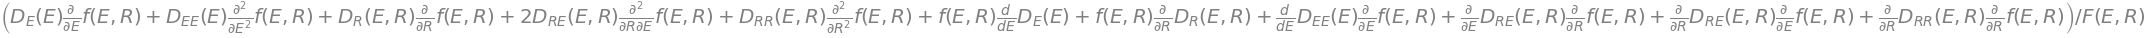

In [43]:
sol.simplify()

In [ ]:
        dE  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=0)
        dE2 = FiniteDifferenceUniformGrid(2, spatial_order, f, axis=0)
        dR  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=1)
        dR2 = FiniteDifferenceUniformGrid(2, spatial_order, f, axis=1)
        
        dER2.matrix = dE.matrix @ dR.matrix = dR.matrix @ dE.matrix
        
        D_EE, D_E, D_ER, D_RR, D_R = self._calc_coefficients()

        dE_D_EE = FiniteDifferenceUniformGrid(1, spatial_order, D_EE, axis=0).operate()
        dE_D_ER = FiniteDifferenceUniformGrid(1, spatial_order, D_ER, axis=0).operate()
        dE_D_E  = FiniteDifferenceUniformGrid(1, spatial_order, D_E, axis=0).operate()   
        dR_D_RR = FiniteDifferenceUniformGrid(1, spatial_order, D_RR, axis=1).operate()
        dR_D_ER = FiniteDifferenceUniformGrid(1, spatial_order, D_ER, axis=1).operate()
        dR_D_R  = FiniteDifferenceUniformGrid(1, spatial_order, D_R, axis=1).operate()
         
        fancy_F = np.sqrt(2)*(np.pi**3.)*(G*M)**(3.) (f.grids[0].values)**(-5./2.)
        
        D_E*dE + D_EE*dE2 + D_R*dR + D_RR*dR2 + f*dE_D_E + f*dR_D_R + dE*dE_D_EE + dR*dE_D_ER + dE*dR_D_ER + dR*dR_D_RR # + 2*D_ER*(second partial)

In [583]:
G = 6.674e-8 # gravitational constant, cgs
m = 2e33     # 1 solar mass in grams
M = 2e41     # 1e8 solar mass SMBH
N = 1e4      # number of stars in distribution
Rstar = 7e10 #stellar radius in cm
Rt = Rstar*(M/m)**(1/3)
Et = G*M/(2*Rt)


class FP_diffusion_2D:
    
    def __init__(self, X, dx2, dy2):
        
        self.X = X
        p = X.field_list[0]        
        self.domain = p.domain
        
        pt = Field(self.domain)
        
        LHS = pt - dx2 - dy2
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
        
        #self.F_ops = [dx2+dy2]
               
class FP_drift_2D:
    
    def __init__(self, X, dx, dy):
        
        self.X = X
        p = X.field_list[0]
        self.domain = p.domain

        pt = Field(self.domain)
        
        LHS = pt + dx + dy
        
        self.M = LHS.field_coeff(pt)
        self.L = LHS.field_coeff(p)
        
        #self.F_ops = []
        #self.F_ops = [-dx - dy]
    

    
class FokkerPlanck_SC:
    
    def __init__(self, X, rgrid, spatial_order=4):
      
        self.X = X
        self.r = rgrid
        f = self.X.field_list[0]
        
        self.domain = f.domain
        self.spatial_order = spatial_order

        
        # Returns field.Array instances: 
        self.dE  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=0)
        self.dE2 = FiniteDifferenceUniformGrid(2, spatial_order, f, axis=0)
        self.dR  = FiniteDifferenceUniformGrid(1, spatial_order, f, axis=1)
        self.dR2 = FiniteDifferenceUniformGrid(2, spatial_order, f, axis=1)
        
        f0 = 1
        self.f0 = f0
        convergence_order = 4
        self.BCs = [Left(0,convergence_order,f,f0,axis=0),Right(0,convergence_order,f,0,axis=0),
                   Left(0,convergence_order,f,0,axis=1),Right(0,convergence_order,f,0,axis=1)]
        
        
 #       self.ts = CrankNicolson(self,axis='full')
        
        self.t = 0.
        self.iter = 0
        
    def _potential(self,r):
        # For now, assumes SMBH potential
        return G*M/r
    
    def _dpotential_dr(self,r):
        # For now, assumes SMBH potential
        return -G*M/r/r


    def _calc_fbar(self):
        f = self.X.field_list[0]
        
        grid_E = f.domain.grids[0]
        grid_R = f.domain.grids[1]
        fbar_domain = field.Domain((grid_E, self.r))
        fbar = field.Field(fbar_domain)

        E_data = np.copy(grid_E.values)
        R_data = np.copy(grid_R.values)
        r_data = np.copy(self.r.values)


        # Construct an integrand that is a 3D grid in (E, r, R) space; trapz() will integrate out the R dimension. 
        r = r_data[None,:,None]
        E = E_data[:,None,None]
        R = R_data[None,None,:]

        Jc   = np.sqrt(-self._dpotential_dr(r)*r**3.)

        Rmax = 2*r*r*(self._potential(r)-E)/Jc**2.
        
        # R varies from 0 to Rmax. Assume R grid starts at 0!
        integrand = f.data[:,None,:]/(Rmax - R)**0.5
        # only integrate from 0 to Rmax # R is only defind from 0 to 1
        integrand[R>=Rmax] = 0 
        
        # NK: bool1 is a bandaid fix, but makes sense: considers only bound orbits 
        #
        arg = (1./2./Rmax[:,:,0]**0.5)
        bool1 = Rmax[:,:,0]<0     
        arg[bool1] = 0

        # for output data
        np.copyto(fbar.data, arg*trapz(integrand, R, axis=-1))
        #print("[_calc_fbar] fbar.data = ", fbar.data.min(), fbar.data.max())
        #print("[_calc_fbar] integrand = ", integrand.min(), integrand.max())
        #print("[_calc_fbar] arg = ", arg.min(), arg.max())
        #print("[_calc_fbar] f.data[:,None,:] = ", f.data[:,None,:].min(), f.data[:,None,:].max())

        return fbar

    def _calc_F012(self, fbar):
        Lambda = 0.4*N
        Gamma = 4*np.pi*G*G*m*m*np.log(Lambda) # Lambda ~ logarithmic cutoff factor, G ~ gravitational constant, m ~ mass of individual star

        grid_E = fbar.domain.grids[0]
        grid_r = fbar.domain.grids[1]    

        # Check to make sure arrays dont occupy same place in memory. the '[:]' part does this for us, I think?
        E_data = np.copy(grid_E.values)
        Eprime_data = np.copy(E_data)
        r_data = np.copy(grid_r.values)
        pot = self._potential(r_data)[None,:,None]
        
        # only integrate between r- and r+
        E  = E_data[:,None,None]
        Ep = Eprime_data[None,None,:]
        r  = r_data[None,:,None]
        ## potential bool
        pot_bool = np.repeat((pot <= E_data).astype(int),len(Eprime_data),-1)
        
        ### F0
        F0_integrand = np.copy(fbar.data[:,:,None])*(E<Ep) 
        F0_bool = (Ep >= E).astype(int)
        F0_bool = np.repeat(F0_bool,len(r_data),axis=1) # extend through r dimension
        F0_integrand[F0_bool] = 0 # Probably redundant, but the *(E<Ep) wont catch nans
        F0 = 4*np.pi*Gamma*trapz(F0_integrand, Ep,axis=-1)

        ### F1
        F1_integrand = fbar.data[:,:,None] * ((pot - Ep))**(0.5)/((pot - E)**(0.5))
        F1_bool1  = np.logical_or(Ep <= E, Ep>=pot)
        F1_integrand[F1_bool1] = 0 # E is lower bound
        F1 = 4*np.pi*Gamma*trapz(F1_integrand, Ep,axis=-1)

        ### F2 (same bounds as F1)
        F2_integrand = fbar.data[:,:,None] * ((pot - Ep)/(pot - E))**(1.5)# * (Ep > E) * (Ep < pot)
        F2_integrand[F1_bool1] = 0
        F2 = 4*np.pi*Gamma*trapz(F2_integrand, Ep,axis=-1)    
        
        print("gamma = ", Gamma)
        print("F0: ", F0.min(), F0.max(), F0_integrand.min(), F0_integrand.max())
        print("F1: ", F1.min(), F1.max(), F1_integrand.min(), F1_integrand.max())
        print("F2: ", F2.min(), F2.max(), F2_integrand.min(), F2_integrand.max())

        return F0, F1, F2

    def _calc_diffusion_coefficients(self, fbar, F0, F1, F2):
        f = self.X.field_list[0]
        grid_E = fbar.domain.grids[0]
        grid_R = f.domain.grids[1]
        grid_r = fbar.domain.grids[1]

        E = grid_E.values[:,None,None]
        R = grid_R.values[None,:,None]
        r = grid_r.values[None,None,:]
        

        
        target_shape = (len(grid_E.values),len(grid_R.values))
        
        # Need to calculate: vc, vt, vr, v, Jc, J
        Jc   = np.sqrt(-1*self._dpotential_dr(r)*r**3.) # angular momentum of circular orbit at given radius
        rc   = E/(2*G*M)                       # circular radius associated with E (E is the negative specific energy, i.e. is positive for all bound orbits)
        # R = (J/Jc)^2
        J    = np.sqrt(R)*Jc                  # angular momentum
        ## integrate only between r- and r+ 
        GM = G*M
        r_minus = 0.5*(GM/E)*(1 - np.sqrt(1. - R))# 4*E*J*J/GM/GM))
        r_plus  = 0.5*(GM/E)*(1 + np.sqrt(1. - R))#4*E*J*J/GM/GM))
        pot  = self._potential(r)    # potential energy (positive)
        v2   = 2*(pot - E)           # total velocity squared
        vr2 = v2 - J*J/r/r
        vr   = (vr2)**(0.5) # radial velocity
        vt   = (v2 - vr2)**(0.5)   # tangential velocity
        vc   = Jc*Jc/rc/rc           # tangential velocity associated with a circular orbit
        
        # calculate integrals
        dr = self.r.values[1]-self.r.values[0]
        bool1 = (r<=(r_minus))
        bool2 = (r>=(r_plus))
        r_bool = np.logical_or(bool1,bool2)

        ## Appendix C of Cohn 1979
        # D_EE  
        #D_EE_integrand = v2*(F0[:,None,:]+F2[:,None,:])
        D_EE_integrand = (1./vr)*v2*(F0[:,None,:]+F2[:,None,:])
        D_EE_integrand[r_bool] = 0
        D_EE_integrand[np.isnan(D_EE_integrand)] = 0
        D_EE           = 8*np.pi*np.pi/3*Jc*Jc * trapz(D_EE_integrand, r, axis = -1)
        
        # D_E
        D_E_integrand  = F1[:,None,:]/vr*bool1*bool2
        D_E_integrand[r_bool] = 0
        D_E_integrand[np.isnan(D_E_integrand)] = 0
        D_E            = -8.*np.pi*np.pi*Jc*Jc * trapz(D_E_integrand, r, axis = -1)

        # D_ER
        D_ER_integrand = (v2/vc/vc - 1)/vr * (F0[:,None,:]+F2[:,None,:])
        D_ER_integrand[r_bool] = 0
        D_ER_integrand[np.isnan(D_ER_integrand)] = 0
        D_ER           = 16*np.pi*np.pi/3.*J*J * trapz(D_ER_integrand, r, axis = -1)

        # D_RR
        D_RR_integrand = (1./v2)*(2*r*r/v2 * ( vt*vt*(v2/vc/vc - 1)**2. + vr*vr)*F0[:,None,:] + 3*r*r*vr*vr/v2*F1[:,None,:] + r*r/v2*(2*vt*vt*(v2/vc/vc - 1)**2. - vr*vr)*F2[:,None,:])
        D_RR_integrand[r_bool] = 0
        D_RR_integrand[np.isnan(D_RR_integrand)] = 0
        D_RR           = 16*np.pi*np.pi/3. * R * trapz(D_RR_integrand, r, axis = -1)

        # D_R
        D_R_integrand  = (1./vr)*(1. - vc*vc/v2)*F1[:,None,:]
        D_R_integrand[r_bool] = 0
        D_R_integrand[np.isnan(D_R_integrand)] = 0
        D_R            = (-16*np.pi*np.pi*R*rc*rc).reshape(target_shape) * trapz(D_R_integrand, r, axis = -1)
        
        
        return D_EE, D_E, D_ER, D_RR, D_R
    
    def _calc_F(self, fbar):
        f = self.X.field_list[0]
        grid_E = fbar.domain.grids[0]
        grid_R = f.domain.grids[1]
        grid_r = fbar.domain.grids[1]

        E = grid_E.values[:,None,None]
        R = grid_R.values[None,:,None]
        r = grid_r.values[None,None,:]
        Jc   = np.sqrt(-1*self._dpotential_dr(r)*r**3.) # angular momentum of circular orbit at given radius
        rc   = E/(2*G*M)                       # circular radius associated with E (E is the negative specific energy, i.e. is positive for all bound orbits)
        # R = J/Jc
        J    = np.sqrt(R)*Jc                  # angular momentum
        pot  = self._potential(r)    # potential energy (positive)
        v2   = 2*(pot - E)           # total velocity squared
        vr   = (v2 - J*J/r/r)**(0.5) # radial velocity
        
        GM = G*M
        
        r_minus = 0.5*(GM/E)*(1 - np.sqrt(1. - 4*E*J*J/GM/GM))
        r_plus  = 0.5*(GM/E)*(1 + np.sqrt(1. - 4*E*J*J/GM/GM))
        
        
        bool1 = (r>r_minus).astype(int)
        bool2 = (r<r_plus).astype(int)
        vr    = np.sqrt(2*GM/r - 2*E - J*J/r/r)

        integrand = 1/vr * bool1 * bool2
        F = trapz(integrand,r,axis=-1)
        
        return F*Jc*Jc*4*np.pi*np.pi
        
    def _calc_coefficients(self):
        fbar     = self._calc_fbar()
        F0,F1,F2 = self._calc_F012(fbar)
        D_EE, D_E, D_ER, D_RR, D_R = self._calc_diffusion_coefficients(fbar,F0,F1,F2)        
        F = self._calc_F(fbar)
    
        domain = self.X.field_list[0].domain
        return field.Array(domain,D_EE), field.Array(domain,D_E), field.Array(domain,D_ER), field.Array(domain,D_RR), field.Array(domain,D_R), field.Array(domain,1/F)
    
    def _recalc_equation(self):
        D_EE, D_E, D_ER, D_RR, D_R, Finv = self._calc_coefficients()

        dE_D_EE = FiniteDifferenceUniformGrid(1, self.spatial_order, D_EE, axis=0).operate()
        dE_D_ER = FiniteDifferenceUniformGrid(1, self.spatial_order, D_ER, axis=0).operate()
        dE_D_E  = FiniteDifferenceUniformGrid(1, self.spatial_order, D_E, axis=0).operate()   
        dR_D_RR = FiniteDifferenceUniformGrid(1, self.spatial_order, D_RR, axis=1).operate()
        dR_D_ER = FiniteDifferenceUniformGrid(1, self.spatial_order, D_ER, axis=1).operate()
        dR_D_R  = FiniteDifferenceUniformGrid(1, self.spatial_order, D_R, axis=1).operate()
         
        f       = self.X.field_list[0]
        print('D_E: ', D_E.data.min(), D_E.data.max())
        print('D_EE: ', D_EE.data.min(), D_EE.data.max())
        print('D_R: ', D_R.data.min(), D_R.data.max())
        print('D_RR: ', D_RR.data.min(), D_RR.data.max())
        print('D_ER: ', D_ER.data.min(), D_ER.data.max())
        print('D_E: ', D_E.data.min(), D_E.data.max())
        print('dE_D_E: ', dE_D_E.data.min(), dE_D_E.data.max())
        print('dE_D_EE: ', dE_D_EE.data.min(), dE_D_EE.data.max())
        print('dE_D_ER: ', dE_D_ER.data.min(), dE_D_ER.data.max())
        print('dR_D_R: ', dR_D_R.data.min(), dR_D_R.data.max())
        print('dR_D_RR: ', dR_D_RR.data.min(), dR_D_RR.data.max())
        print('dR_D_ER: ', dR_D_ER.data.min(), dR_D_ER.data.max())

        ft     = field.Field(domain)
        LHS = ft - ( (D_E*self.dE + D_EE*self.dE2 + D_R*self.dR + D_RR*self.dR2 + f*dE_D_E + f*dR_D_R + self.dE*dE_D_EE + self.dR*dE_D_ER + self.dE*dR_D_ER + self.dR*dR_D_RR)) # + 2*D_ER*(second partial)         
        
        
        M = LHS.field_coeff(ft)
        M = M.tocsr()
        print('b M : ', M.min(), M.max())
        M[:1,:] = 0#self.BCs[0].field_coeff(ft,axis=0)
        M[-1:,:] = 0#self.BCs[1].field_coeff(ft,axis=0)
        M[:,:1] = 0#self.BCs[2].field_coeff(ft,axis=1)
        M[:,-1:] = 0#self.BCs[3].field_coeff(ft,axis=1)
        
        print('a M : ', M.min(), M.max())
        M.eliminate_zeros()
        self.M = M
    
        L = LHS.field_coeff(f)
        L = L.tocsr()
        print('b L : ', L.min(), L.max())
        L[:1,:] = self.f0#self.BCs[0].field_coeff(f,axis=0)
        L[-1:,:] = 0#self.BCs[1].field_coeff(f,axis=0)
        L[:,:1] = 0#self.BCs[2].field_coeff(f,axis=1)
        L[:,-1:] = 0#self.BCs[3].field_coeff(f,axis=1)
        print('a L : ', L.min(), L.max())
        L.eliminate_zeros()
        self.L = L
        
        
    def step(self, dt):

        self._recalc_equation()
        self.ts = CrankNicolson(self,axis='full')
        self.ts.step(dt)
        self.t += dt
        self.iter += 1

In [584]:
print(G*M/rmax)
print(G*M/Rt)
print(Et)
print(E_min)

4.1081991775065134e+18
4.108199177506513e+20
2.0540995887532566e+20
4.1081991775065134e+18


In [585]:
N = 100
spatial_order = 4

a = 0.4
b = 0.5

#E_min = 1e-3
rmax  = 100*Rt
E_min = G*M/(rmax) # need 1.5 safety factor to avoid unbound orbits


grid_E = field.UniformNonPeriodicGrid(N,[E_min,Et])
grid_R = field.UniformNonPeriodicGrid(N,[0,1])
domain = field.Domain((grid_E, grid_R))
f = field.Field(domain)

f.data = (a*grid_E.values[:,None]+b*grid_R.values[None,:])/1e18

X = field.FieldSystem([f])

rgrid = field.UniformNonPeriodicGrid(N,[Rt,rmax])


E_data = np.copy(grid_E.values)
R_data = np.copy(grid_R.values)
r_data = np.copy(rgrid.values)


# Construct an integrand that is a 3D grid in (E, r, R) space; trapz() will integrate out the R dimension. 
r = r_data[None,:,None]
E = E_data[:,None,None]
R = R_data[None,None,:]

Jc   = np.sqrt(G*M*r)



FP_SC = FokkerPlanck_SC(X,rgrid)

v = np.sqrt(G*M/rmax)
#t_relax = 0.1*N/(np.log(N))*rmax/v
t_relax = 0.0600 * M**(1/2)*rmax**(3/2)/m/G**(1/2)/np.log(0.4*N)

alpha = .1

t_max = t_relax
dt = alpha*t_relax
while FP_SC.t < t_max:
    FP_SC.step(dt)
    
R_ind = N//2

#plt.plot(grid_E.values, dER_field.data[:,R_ind],label='appx')
#plt.legend(loc='upper left', frameon=False)

#plt.ylim(0,5e16)'''

<ipython-input-583-0d3445ac6753>:109: RuntimeWarning: invalid value encountered in sqrt
  integrand = f.data[:,None,:]/(Rmax - R)**0.5
<ipython-input-583-0d3445ac6753>:115: RuntimeWarning: invalid value encountered in sqrt
  arg = (1./2./Rmax[:,:,0]**0.5)
<ipython-input-583-0d3445ac6753>:156: RuntimeWarning: invalid value encountered in sqrt
  F1_integrand = fbar.data[:,:,None] * ((pot - Ep))**(0.5)/((pot - E)**(0.5))
<ipython-input-583-0d3445ac6753>:162: RuntimeWarning: invalid value encountered in power
  F2_integrand = fbar.data[:,:,None] * ((pot - Ep)/(pot - E))**(1.5)# * (Ep > E) * (Ep < pot)
<ipython-input-583-0d3445ac6753>:199: RuntimeWarning: invalid value encountered in sqrt
  vr   = (vr2)**(0.5) # radial velocity
<ipython-input-583-0d3445ac6753>:259: RuntimeWarning: invalid value encountered in sqrt
  vr   = (v2 - J*J/r/r)**(0.5) # radial velocity
<ipython-input-583-0d3445ac6753>:263: RuntimeWarning: invalid value encountered in sqrt
  r_minus = 0.5*(GM/E)*(1 - np.sqrt(1. - 4

gamma =  8.259176049894964e+53
F0:  0.0 8.325947108171213e+76 0.0 90.68914214492382
F1:  0.0 3.286024659531777e+76 0.0 89.54745193269741
F2:  0.0 2.5401848098201037e+76 0.0 87.30700895642698
D_E:  -0.0 -0.0
D_EE:  0.0 1.492275677947434e+153
D_R:  -0.0 5.885605253201554e+192
D_RR:  0.0 8.353726258229106e+102
D_ER:  -1.5806422638584306e+133 0.0
D_E:  -0.0 -0.0
dE_D_E:  0.0 0.0
dE_D_EE:  -4.8869209115082144e+134 4.669714647781801e+134
dE_D_ER:  -5.141405686296893e+114 5.186468237861821e+114
dR_D_R:  -1.7177432131718233e+194 2.173041545116446e+194
dR_D_RR:  -3.058021740787876e+104 4.8577743507019616e+104
dR_D_ER:  -1.0012379330617882e+135 1.0372649615537003e+135
b M :  0.0 1.0
a M :  0.0 1.0
b L :  0.0 0.0
a L :  0.0 1.0


RuntimeError: Factor is exactly singular

In [ ]:
a = 2*np.ones((10,1,10))
b = np.ones(10)[None,:,None]
b = np.repeat(b,10,axis=-1)
print(b.shape)
#c = a*b
#print(c.shape)
#print(c)

In [ ]:
a = np.ones(10)*5
b = np.arange(10)
print(a.shape,b.shape)

bool1 = a[:,None] > b[None,:]
bool2 = bool1[:,None]
bool3 = bool1[None,:]

bool4 = (bool1 or bool2).any()
print(bool4.shape)

print(bool1.shape,bool1)

In [510]:
a = 1./np.array([1.,0.,3.])
print(a*[1,0,1])

[1.                nan 0.33333333]


<ipython-input-510-707366219f6d>:1: RuntimeWarning: divide by zero encountered in true_divide
  a = 1./np.array([1.,0.,3.])
<ipython-input-510-707366219f6d>:2: RuntimeWarning: invalid value encountered in multiply
  print(a*[1,0,1])
